In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint
import dataclasses

from tqdm import tqdm, trange

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2 as cv

import fish

In [2]:
NOTEBOOK_NAME = "_template"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\fish\dev
D:\projects\fish\data
D:\projects\fish\dev\out\_template


In [3]:
frames = fish.cached_read(DATA / "D1-1.hsv")

DEBUG:fish.io:Cached read from D:\projects\fish\data\D1-1.hsv.cached


In [4]:
bgnd = fish.background_via_min(frames)

Calculating background: 100%|██████████| 1816/1816 [00:10<00:00, 178.28it/s]


In [5]:
dish = fish.find_dish(bgnd)
dish_mask = dish.mask_like(bgnd)

In [6]:
curr_frame = frames[100]
curr_frame_masked = fish.apply_mask(curr_frame, dish_mask)
curr_frame_masked_no_bgnd = fish.subtract_background(curr_frame_masked, bgnd)

next_frame = frames[101]
next_frame_masked = fish.apply_mask(next_frame, dish_mask)
next_frame_masked_no_bgnd = fish.subtract_background(next_frame_masked, bgnd)

In [7]:
flow = cv.calcOpticalFlowFarneback(
    curr_frame_masked_no_bgnd, next_frame_masked_no_bgnd, None, 
    pyr_scale = 0.5,
    levels = 3,
    winsize = 11,
    iterations = 5,
    poly_n = 5,
    poly_sigma = 1.1,
    flags = cv.OPTFLOW_FARNEBACK_GAUSSIAN,
)

In [8]:
print(curr_frame.shape)
print(flow.shape)
flow_x = flow[..., 0]
flow_y = flow[..., 1]

(1024, 1280)
(1024, 1280, 2)


<ipython-input-9-0941e7799582>:8: UserWarning: tight_layout : falling back to Agg renderer
  fig.tight_layout()


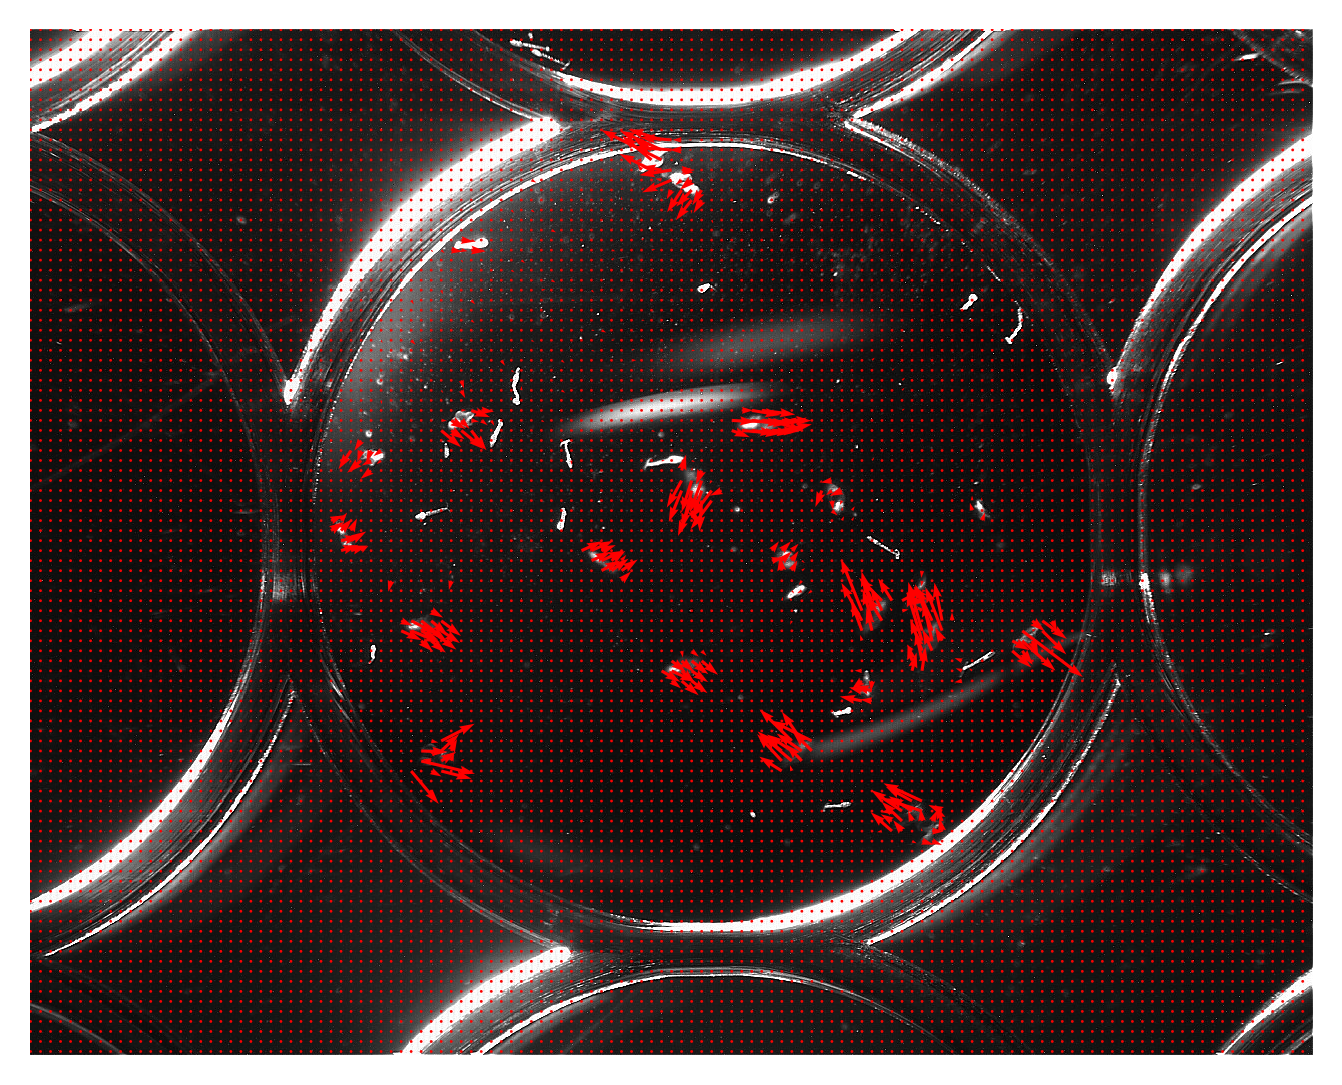

In [9]:
fig = plt.Figure(figsize = (6,4), dpi = 300)
ax = fig.add_subplot(111)

ax.imshow(curr_frame, cmap="gray", vmin=0, vmax=255)
ax.quiver(np.arange(1280)[::10], np.arange(1024)[::10], flow_x[::10, ::10], flow_y[::10, ::10], 
          color = 'red', scale = 400, pivot = 'tail')

fig.tight_layout()
ax.axis('off')

fig

In [10]:
velocity_norm = np.linalg.norm(flow, axis = -1)
velocity_norm_image = (velocity_norm * 255 / np.max(velocity_norm)).astype(np.uint8)

(1024, 1280)


D:\projects\fish\fish\figs.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


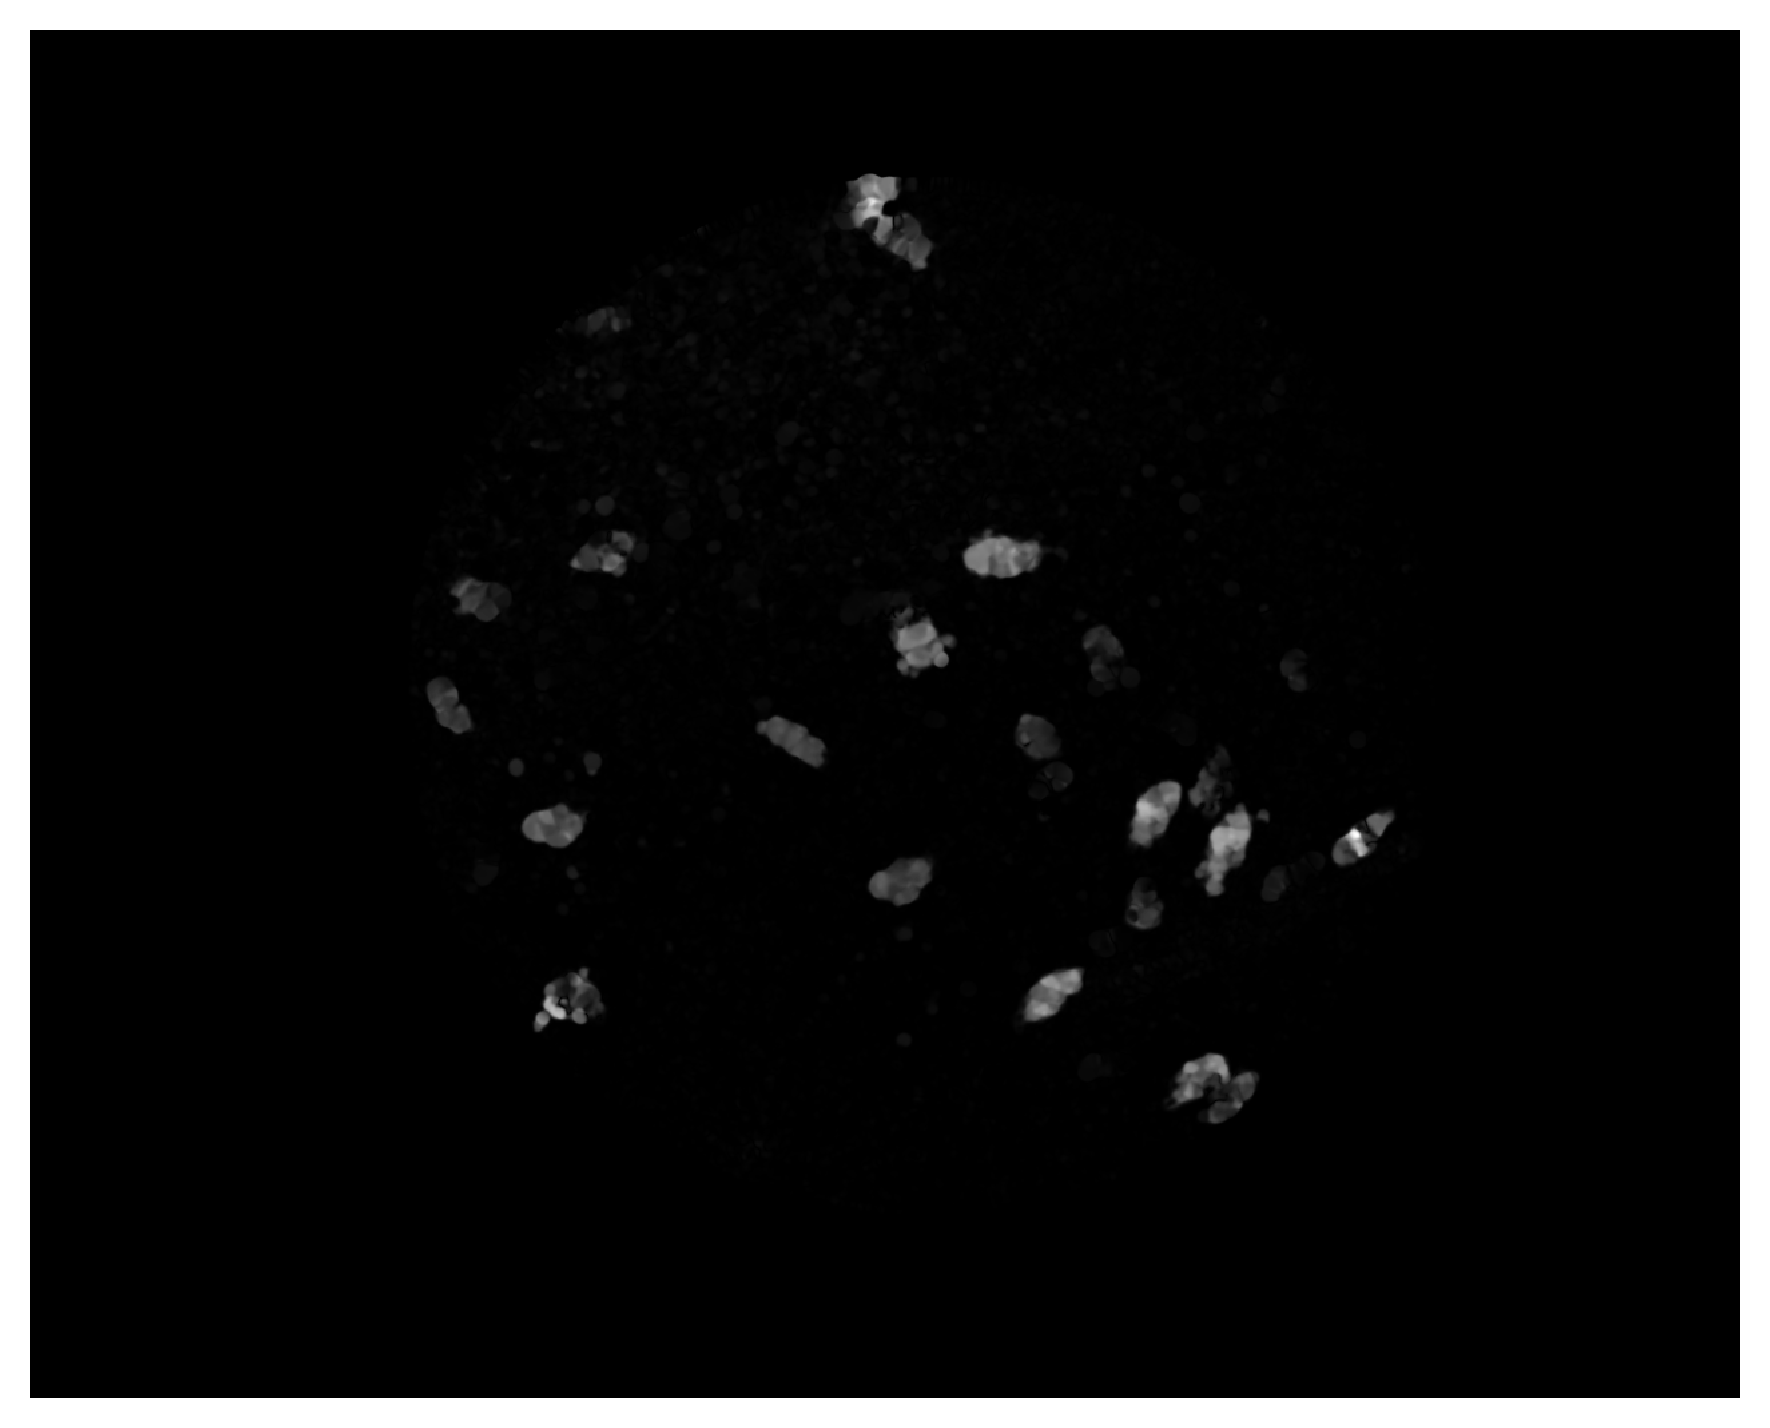

In [11]:
print(velocity_norm.shape)
fish.show_frame(velocity_norm * 255 / np.max(velocity_norm))

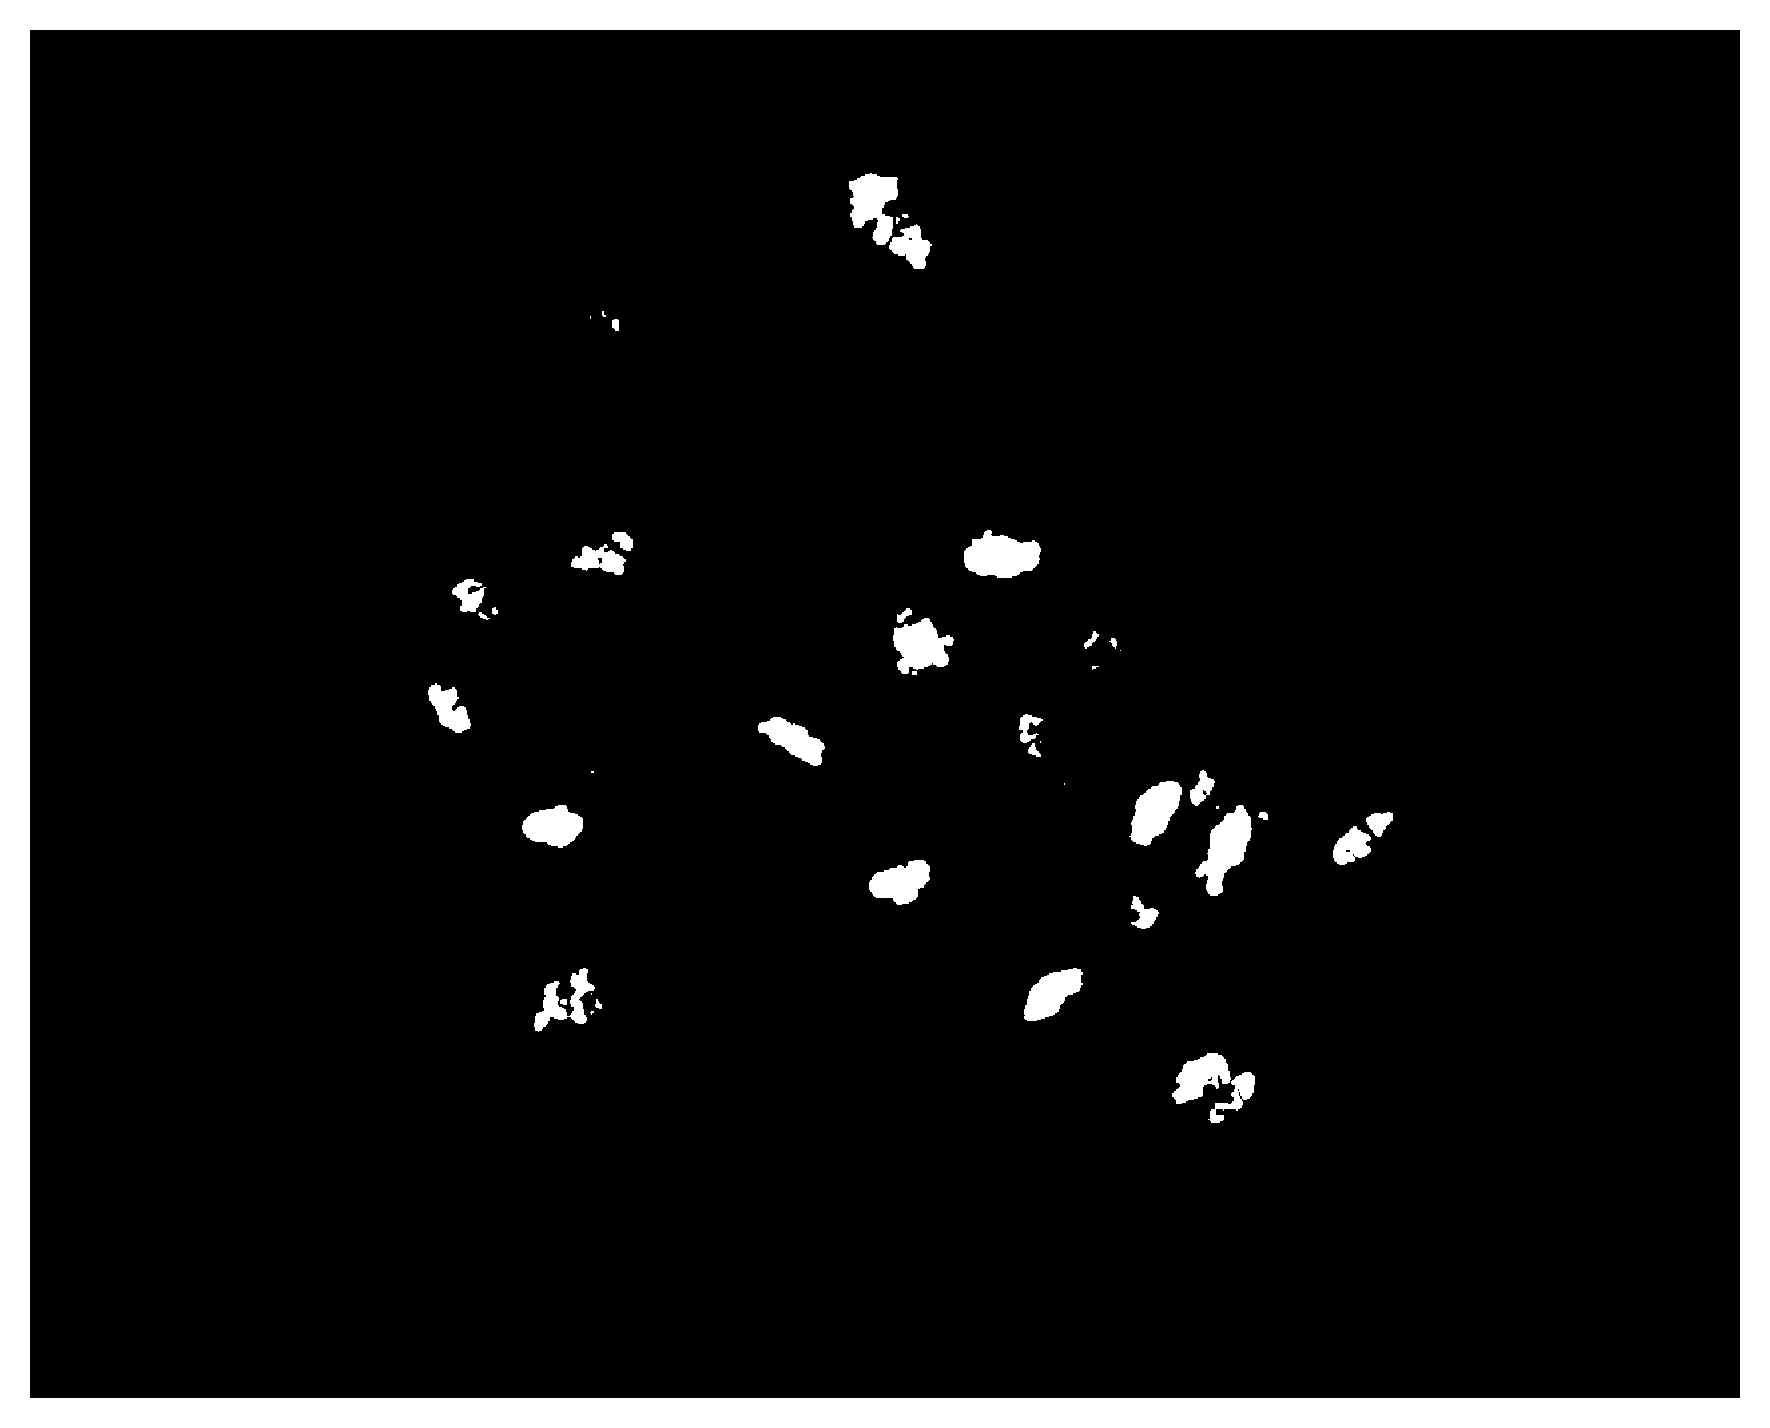

In [12]:
thresh, thresholded = cv.threshold(
    velocity_norm_image, thresh=0, maxval=255, type=cv.THRESH_OTSU
)
fish.show_frame(thresholded)

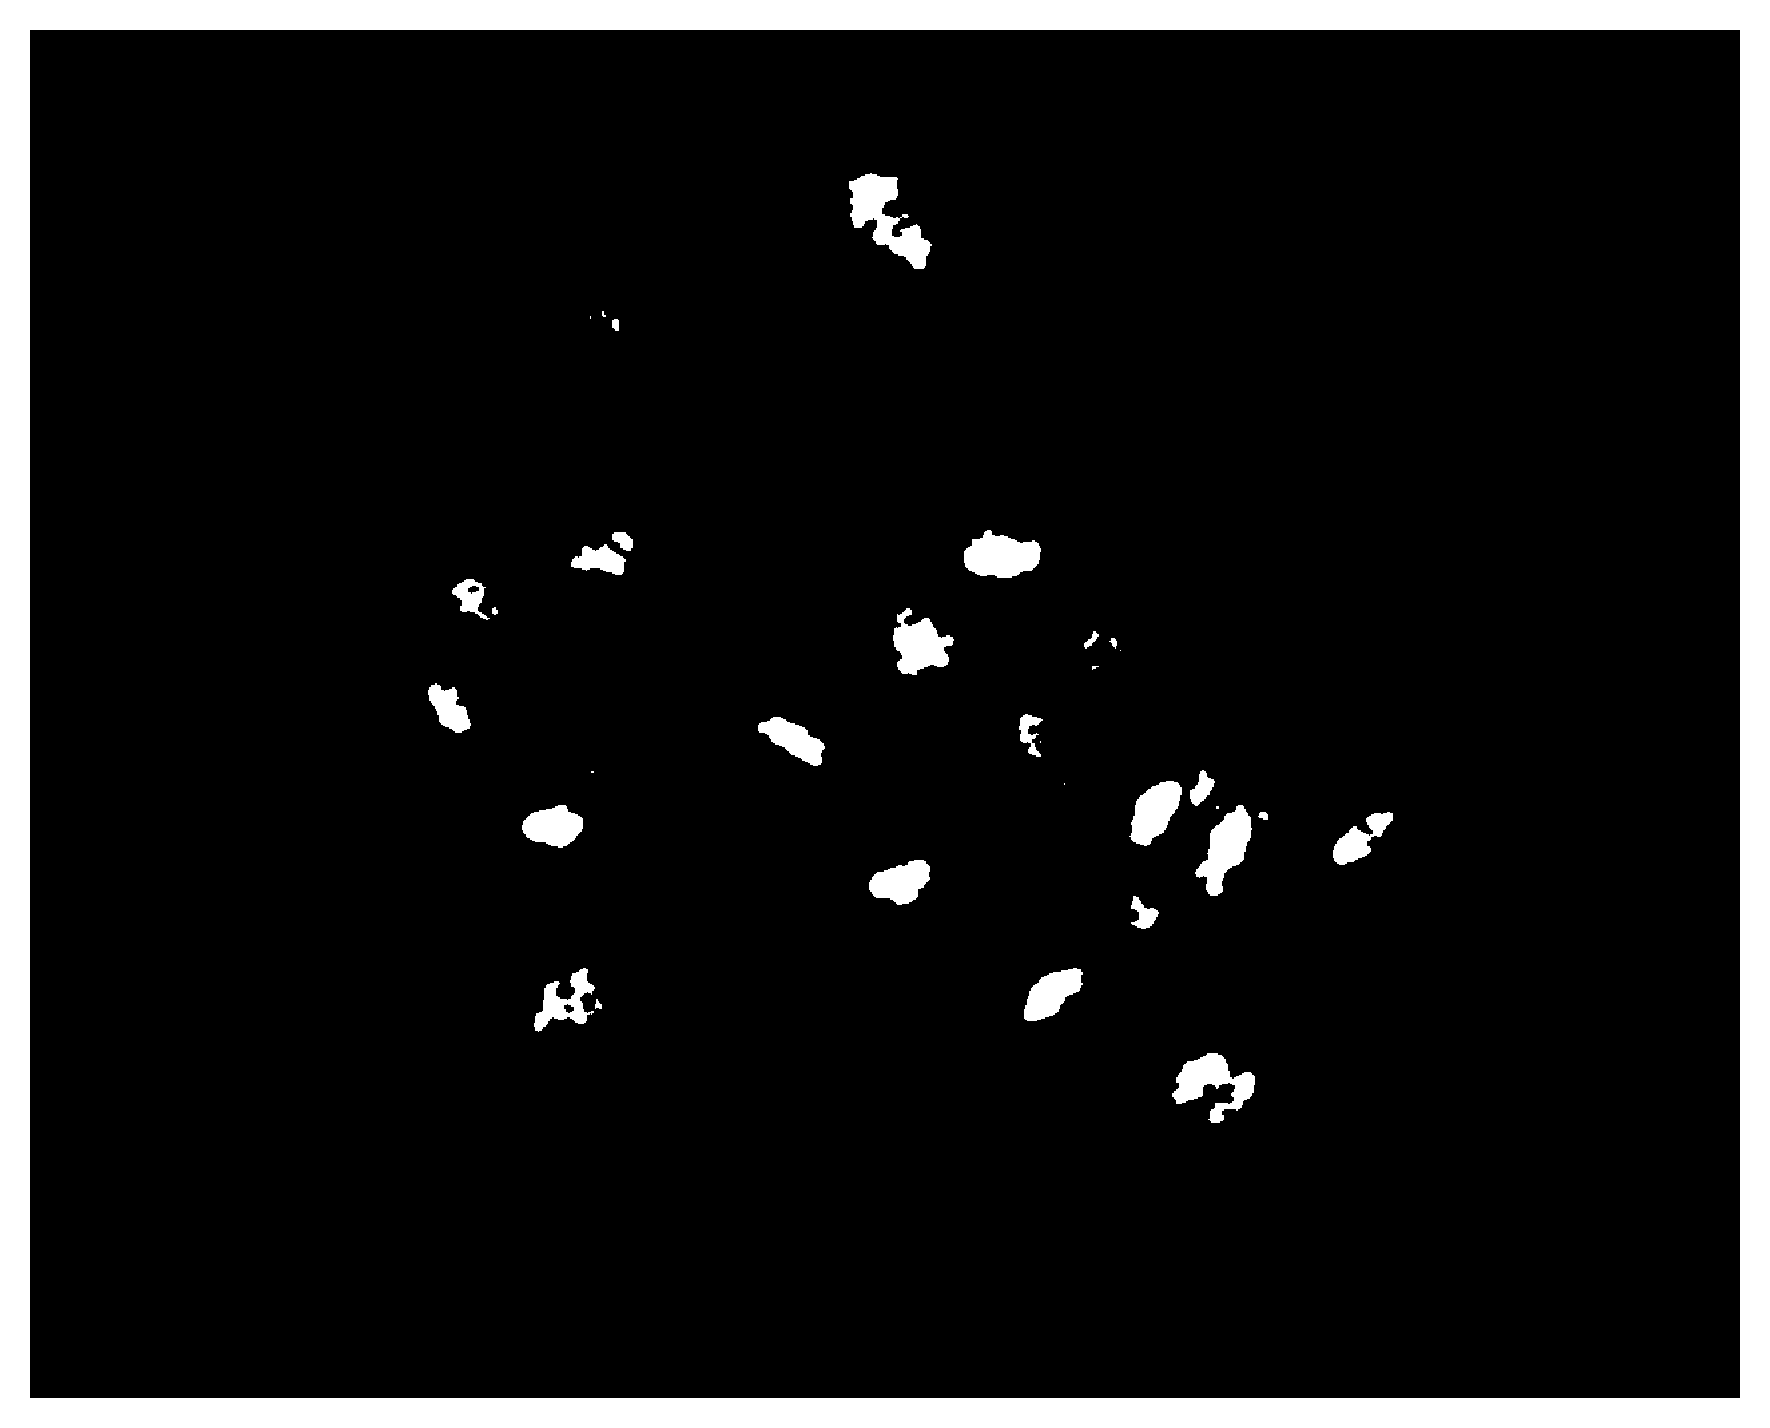

In [13]:
KERNEL_SIZE = 5
KERNEL = cv.getStructuringElement(
    cv.MORPH_ELLIPSE, (KERNEL_SIZE, KERNEL_SIZE)
)
closed_thresholded = cv.morphologyEx(thresholded, cv.MORPH_CLOSE, KERNEL)

fish.show_frame(closed_thresholded)

In [14]:
class VelocityBlob:
    def __init__(self, label, area, centroid, centroid_velocity):
        self.label = label
        self.area = area
        self.centroid = centroid
        self.centroid_velocity = centroid_velocity
        self.centroid_velocity_tangent = np.array([self.v_y, -self.v_x])
        
    @property
    def x(self):
        return self.centroid[0]
    
    @property
    def y(self):
        return self.centroid[1]
    
    @property
    def v_x(self):
        return self.centroid_velocity[0]
    
    @property
    def v_y(self):
        return self.centroid_velocity[1]
    
    @property
    def v_t_x(self):
        return self.centroid_velocity_tangent[0]
    
    @property
    def v_t_y(self):
        return self.centroid_velocity_tangent[1]
    
    @property
    def v_unit(self):
        return self.centroid_velocity / np.linalg.norm(self.centroid_velocity)
    
    @property
    def v_t_unit(self):
        return self.centroid_velocity_tangent / np.linalg.norm(self.centroid_velocity_tangent)

In [15]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(closed_thresholded, 8)

In [16]:
LOW_AREA = 100
filtered_threshold = np.zeros_like(closed_thresholded)

velocity_blobs = {}

y = np.arange(1024)
x = np.arange(1280)
flow_x_interp = sp.interpolate.RegularGridInterpolator((y, x), flow_x)
flow_y_interp = sp.interpolate.RegularGridInterpolator((y, x), flow_y)

for label in range(1, num_labels):
    area = stats[label, cv.CC_STAT_AREA]
    centroid = centroids[label]
    
    if area > LOW_AREA:
        velocity_blobs[label] = VelocityBlob(
            label = label,
            area = area,
            centroid = centroid,
            centroid_velocity = np.array([flow_x_interp(centroid), flow_y_interp(centroid)]),
        )
        filtered_threshold[labels == label] = 255

<ipython-input-14-69087815fc1b>:35: RuntimeWarning: invalid value encountered in true_divide
  return self.centroid_velocity / np.linalg.norm(self.centroid_velocity)
<ipython-input-14-69087815fc1b>:39: RuntimeWarning: invalid value encountered in true_divide
  return self.centroid_velocity_tangent / np.linalg.norm(self.centroid_velocity_tangent)


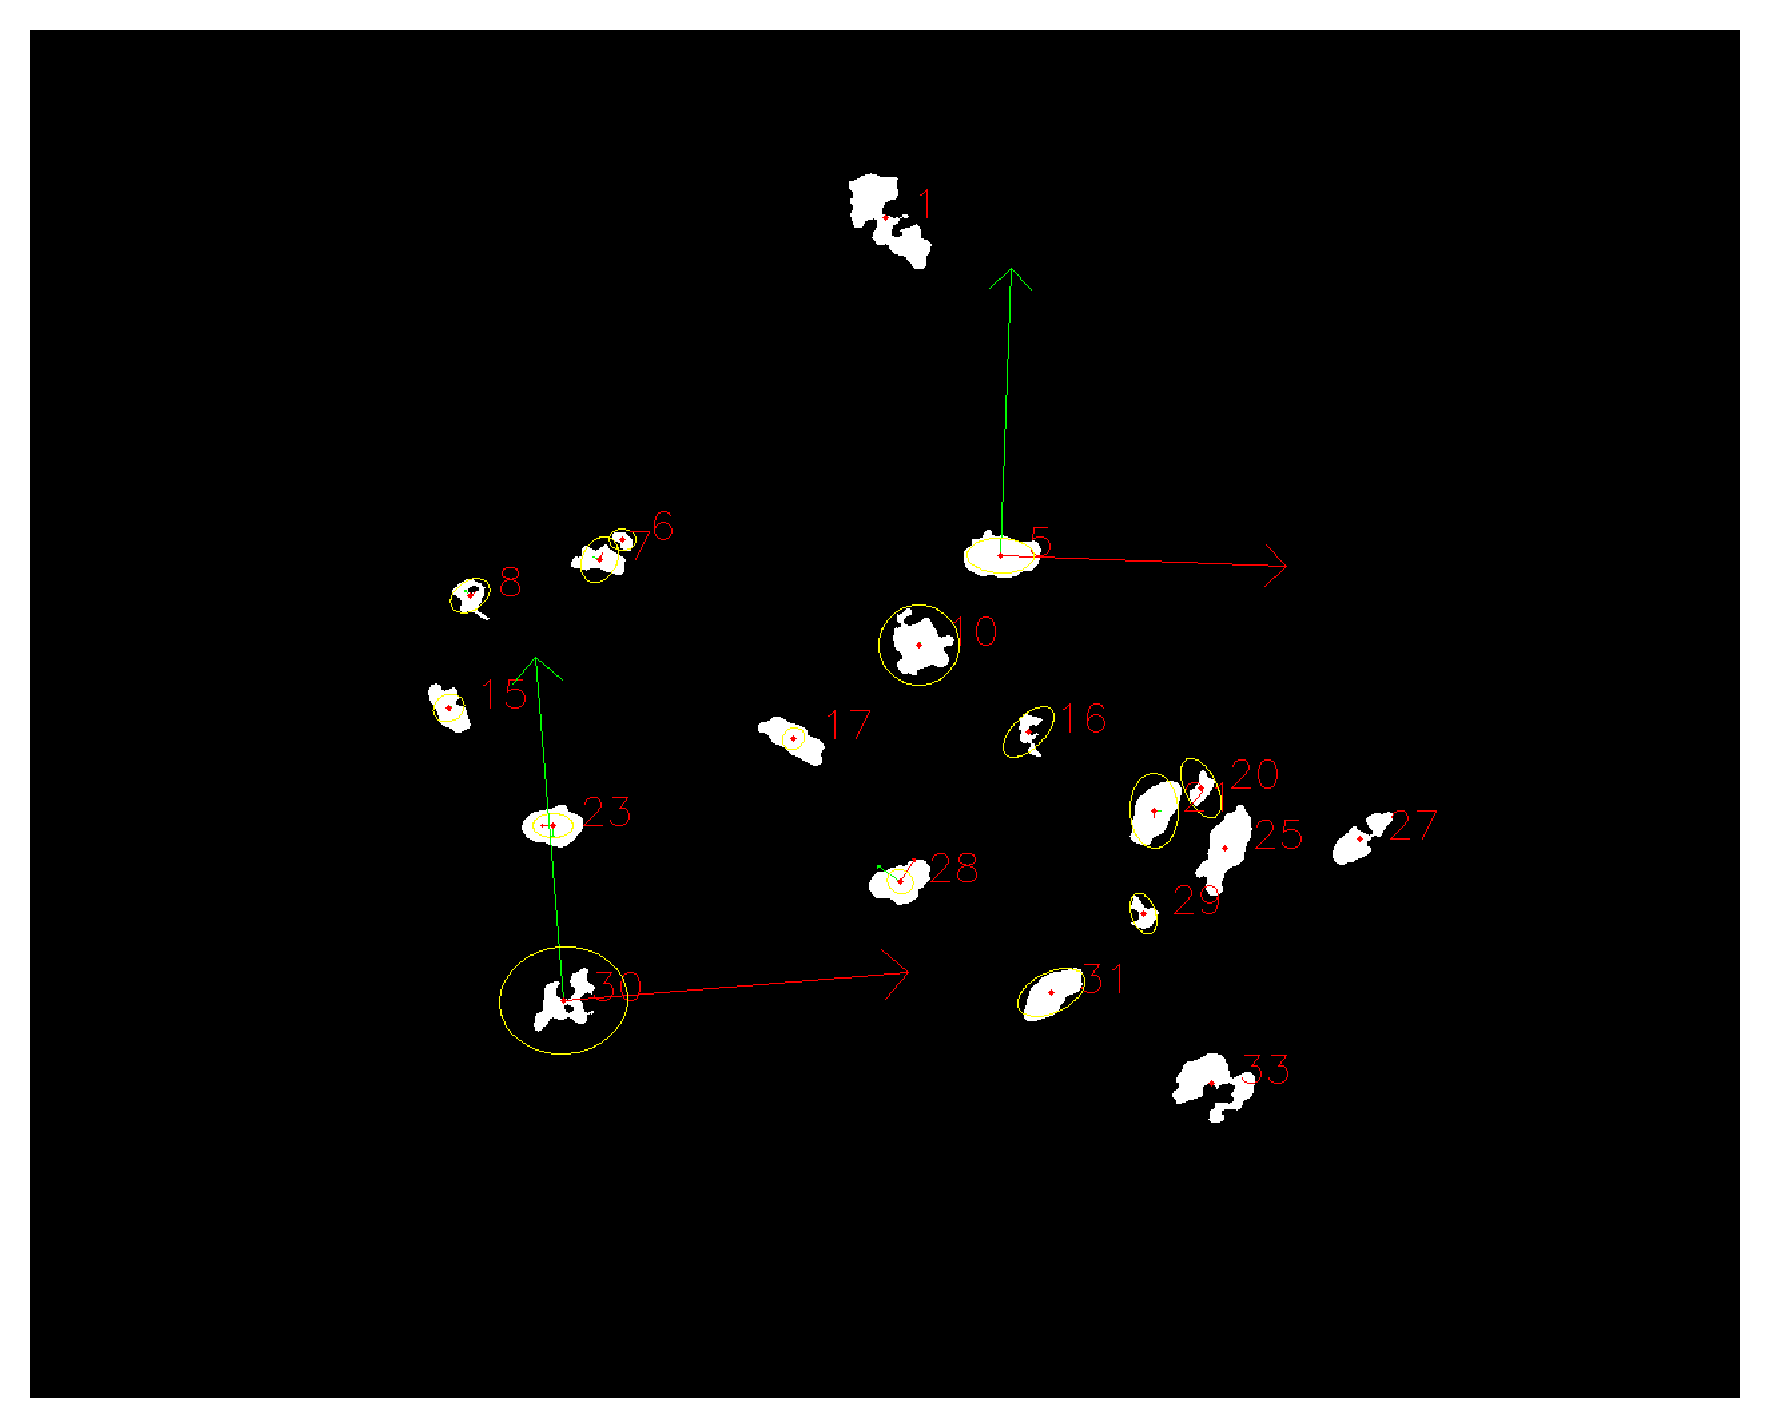

In [24]:
blob_view = fish.bw_to_bgr(filtered_threshold)

ARROW_SCALE = 25
ELLIPSE_SCALE = 10

for label, blob in velocity_blobs.items():
    blob_view = fish.draw_text(blob_view, (blob.x + 20, blob.y), label, color = fish.RED)
    blob_view = fish.draw_arrow(blob_view, (blob.x, blob.y), (blob.x + blob.v_x * ARROW_SCALE, blob.y + blob.v_y * ARROW_SCALE), color = fish.RED)
    blob_view = fish.draw_arrow(blob_view, (blob.x, blob.y), (blob.x + blob.v_t_x * ARROW_SCALE, blob.y + blob.v_t_y * ARROW_SCALE), color = fish.GREEN)
    blob_view = fish.draw_circle(blob_view, (blob.x, blob.y), radius = 2, thickness = -1, color = fish.RED)

    blow_flow = flow[labels == label]
    v_rel = np.dot(blow_flow, blob.v_unit)
    v_rel_mean = np.mean(v_rel)
    v_rel_std = np.std(v_rel)

    v_t_rel = np.dot(blow_flow, blob.v_t_unit)
    v_t_rel_mean = np.sum(v_t_rel[v_t_rel != 0])
    v_t_rel_std = np.std(v_t_rel[v_t_rel != 0])

    if not np.isnan(v_rel_mean):
        blob_view = fish.draw_ellipse(
            blob_view,
            (blob.x, blob.y),
            (v_rel_std * ELLIPSE_SCALE, v_t_rel_std * ELLIPSE_SCALE),
            rotation = np.rad2deg(np.arctan2(blob.v_y, blob.v_x)),
            color = fish.YELLOW,
        )
    

fish.show_frame(fish.bgr_to_rgb(blob_view))

